In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

In [38]:
df = pd.read_csv('bgl.csv')

# Display basic info
print("Initial Data Info:\n")
print(df.info())
df.head()

Initial Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB
None


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [40]:
# --- Block 2: Clean Column Names ---

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(r'\s+', '_', regex=True)
    .str.replace(r'[^a-z0-9_]', '', regex=True)
)

print("Cleaned Column Names:")
print(df.columns)


Cleaned Column Names:
Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [42]:
# --- Block 3: Handle Missing Values ---

# Function to safely get mode
def safe_mode(series):
    try:
        return series.mode(dropna=True).iloc[0]
    except:
        return np.nan

# Fill missing values
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(safe_mode(df[column]), inplace=True)
    else:
        df[column].fillna(df[column].median(), inplace=True)

# Check missing values after filling
df.isnull().sum()


/var/folders/nt/cm9_z_nx5yq0pgqw46gnrd_40000gn/T/ipykernel_9755/2895583027.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(safe_mode(df[column]), inplace=True)
/var/folders/nt/cm9_z_nx5yq0pgqw46gnrd_40000gn/T/ipykernel_9755/2895583027.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

area_type       0
availability    0
location        0
size            0
society         0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

In [44]:
# --- Block 4: Convert 'total_sqft' to numeric ---

def convert_sqft(x):
    try:
        if '-' in str(x):
            a, b = x.split('-')
            return (float(a) + float(b)) / 2
        return float(x)
    except:
        return np.nan

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)

# Drop rows with invalid total_sqft
df.dropna(subset=['total_sqft'], inplace=True)

print("Converted 'total_sqft' to numeric successfully!")
df[['total_sqft', 'price']].head()


Converted 'total_sqft' to numeric successfully!


,total_sqft,price
0,1056.0,39.07
1,2600.0,120.00
2,1440.0,62.00
3,1521.0,95.00
4,1200.0,51.00


In [46]:
# --- Block 5: Feature Engineering ---

# Extract numeric BHK values from 'size' column
def extract_bhk(x):
    if isinstance(x, str):
        match = re.search(r'\d+', x)
        return int(match.group()) if match else np.nan
    return np.nan

if 'size' in df.columns:
    df['bhk'] = df['size'].apply(extract_bhk)

# Create price per sqft (optional)
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']

df[['bhk', 'price_per_sqft']].head()


,bhk,price_per_sqft
0,2,3699.810606
1,4,4615.384615
2,3,4305.555556
3,3,6245.890861
4,2,4250.000000


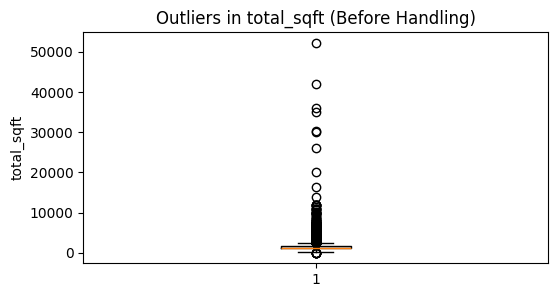

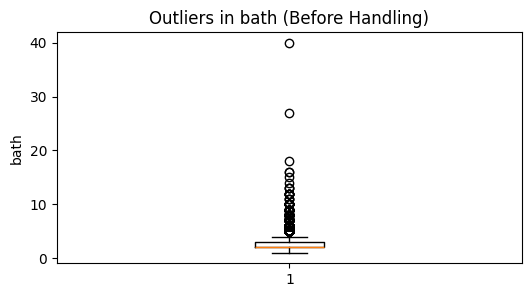

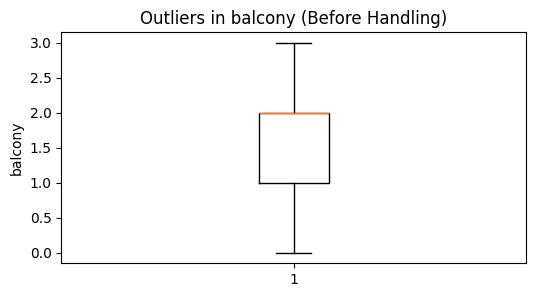

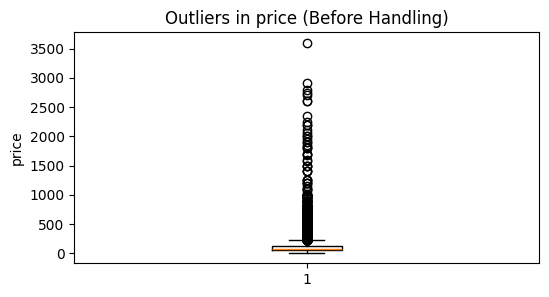

In [48]:
# --- Block 6: Detect and Visualize Outliers (Before Handling) ---

numeric_cols = ['total_sqft', 'bath', 'balcony', 'price']

for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(6, 3))
        plt.boxplot(df[col].dropna())
        plt.title(f'Outliers in {col} (Before Handling)')
        plt.ylabel(col)
        plt.show()


In [50]:
# --- Block 7: Handle Outliers Using IQR ---

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ['total_sqft', 'bath', 'price']:
    df = remove_outliers(df, col)

print("Outliers removed successfully!")
df.describe()


Outliers removed successfully!


,total_sqft,bath,balcony,price,bhk,price_per_sqft
count,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000
mean,1276.219651,2.276919,1.555319,69.925927,2.439311,5496.366069
std,365.694658,0.657488,0.772753,32.169282,0.722936,2225.261286
min,250.000000,1.000000,0.000000,8.000000,1.000000,500.000000
25%,1070.000000,2.000000,1.000000,46.000000,2.000000,4090.909091
50%,1220.000000,2.000000,2.000000,62.500000,2.000000,5032.258065
75%,1491.000000,3.000000,2.000000,88.000000,3.000000,6299.212598
max,2550.000000,4.000000,3.000000,167.000000,8.000000,28571.428571


In [52]:
# --- Block 8: Encode Categorical Variables ---

categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Categorical variables encoded successfully!")
print(f"Encoded dataset shape: {df_encoded.shape}")


Categorical variables encoded successfully!
Encoded dataset shape: (10801, 3580)


In [54]:
# --- Block 9: Aggregation and Insights ---

if 'area_type' in df.columns:
    avg_price_by_area = df.groupby('area_type')['price'].mean().reset_index()
    print("Average Price by Area Type:")
    display(avg_price_by_area)

if 'bhk' in df.columns:
    avg_price_by_bhk = df.groupby('bhk')['price'].mean().reset_index()
    print("\nAverage Price by BHK:")
    display(avg_price_by_bhk)


Average Price by Area Type:


,area_type,price
0,Built-up Area,66.246718
1,Carpet Area,67.982260
2,Plot Area,90.630809
3,Super built-up Area,68.347416



Average Price by BHK:


,bhk,price
0,1,36.857859
1,2,57.495061
2,3,86.501693
3,4,106.953846
4,5,106.969231
5,6,109.560000
6,7,112.000000
7,8,75.333333


In [56]:
# --- Block 10: Save Cleaned Dataset ---

df.to_csv("RealEstate_Cleaned.csv", index=False)
df_encoded.to_csv("RealEstate_Cleaned_Encoded.csv", index=False)

print("✅ Cleaned datasets saved as:")
print("- RealEstate_Cleaned.csv")
print("- RealEstate_Cleaned_Encoded.csv")


✅ Cleaned datasets saved as:
- RealEstate_Cleaned.csv
- RealEstate_Cleaned_Encoded.csv
